<a id='top'> </a>

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-08-09 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.6.0


# Compositon dependence of CR anisotropy
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
2. [Projected relative intensity](#Projected-relative-intensity)
3. [Cross-check: random splitting of events](#Cross-check:-random-splitting-of-events)

In [2]:
%matplotlib inline
from __future__ import division, print_function
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import seaborn.apionly as sns
import healpy as hp
from sklearn.model_selection import KFold
import multiprocessing as mp
import dask
from dask import delayed, multiprocessing
from dask.diagnostics import ProgressBar
import pyprind

from icecube import astro

import comptools as comp
import comptools.analysis.plotting as plotting
import comptools.anisotropy.anisotropy as anisotropy

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [134]:
# config = ['IC86.2012', 'IC86.2013', 'IC86.2014']
# config = ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
# config = ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2015']
# config = ['IC86.2012']
config = comp.datafunctions.get_data_configs()
n_side = 64
smooth_rad = 0.0
scale = 3
decmax = -55
decmin = -90
ramin = 0
ramax = 360
years_str = '2011-2015'
composition='all'
low_energy = True


n_dec_bins = 4
n_ra_bins = 6

In [135]:
kwargs_data = {'config': config, 'low_energy': low_energy, 'smooth': False, 'scale': False, 'decmax': decmax}

In [136]:
n_total = anisotropy.get_num_events(config=config, composition='all', decmax=decmax, low_energy=low_energy)
n_light = anisotropy.get_num_events(config=config, composition='light', decmax=decmax, low_energy=low_energy)
n_heavy = anisotropy.get_num_events(config=config, composition='heavy', decmax=decmax, low_energy=low_energy)

In [137]:
'{:g}'.format(n_total)

'3.49503e+07'

In [138]:
n_light/n_total, n_heavy/n_total

(0.61907019126007723, 0.38092960845530688)

In [139]:
data_all = anisotropy.get_map(name='data', composition='all', **kwargs_data)
data_light = anisotropy.get_map(name='data', composition='light', **kwargs_data)
data_heavy = anisotropy.get_map(name='data', composition='heavy', **kwargs_data)

ref_all = anisotropy.get_map(name='ref', composition='all', **kwargs_data)
ref_light = anisotropy.get_map(name='ref', composition='light', **kwargs_data)
ref_heavy = anisotropy.get_map(name='ref', composition='heavy', **kwargs_data)

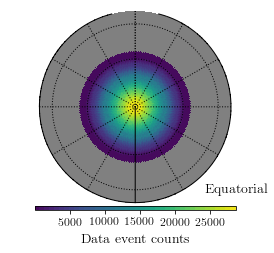

In [140]:
# print(relint_all.max())
# print(relint_all[relint_all != hp.UNSEEN].min())
# data_all = anisotropy.get_map(name='data', composition='all', **kwargs_relint)

title = 'Data event counts'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(data_all,
                                 color_palette='viridis', symmetric=True, llabel=None, 
#                                  color_palette='RdBu_r', symmetric=True, llabel='IC86 ' + years_str, 
                                 cbar_title=title, polar=True, cartesian=False)
outfile = 'IC86-{}_data_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'all', n_side, smooth_rad)
outfile = os.path.join(comp.paths.figures_dir, 'anisotropy', 'skymaps', outfile)
comp.check_output_dir(outfile)
plt.savefig(outfile)

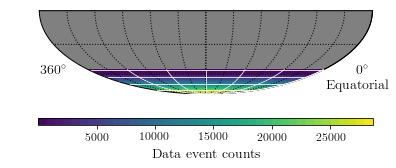

In [141]:
# print(relint_all.max())
# print(relint_all[relint_all != hp.UNSEEN].min())
# data_all = anisotropy.get_map(name='data', composition='all', **kwargs_relint)

title = 'Data event counts'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(data_all,
                                 color_palette='viridis', symmetric=True, llabel=None, 
#                                  color_palette='RdBu_r', symmetric=True, llabel='IC86 ' + years_str, 
                                 cbar_title=title, polar=False, cartesian=False)

npix = len(data_all)
nside = hp.npix2nside(npix)
theta, phi = hp.pix2ang(nside, range(npix))

# Bin in declination
thetamax =  np.deg2rad(90 - decmin)
thetamin = np.deg2rad(90 - decmax)
theta_bins= np.linspace(thetamin, thetamax, n_dec_bins+1)

for theta_bin_edge in theta_bins:
    ra_points = np.linspace(0, 2*np.pi, 100)
    theta_points = [theta_bin_edge]*len(ra_points)
    hp.projplot(theta_points, ra_points,
                marker='None', color='white', ls='-', lw=0.8)


# Bin in right ascension
rabins = np.linspace(ramin, ramax, n_ra_bins+1, dtype=float)

for ra_bin_edge in rabins:
    dec_points = np.linspace(decmin, decmax, 20)
    ra_points = [ra_bin_edge]*len(dec_points)
    hp.projplot(anisotropy.dec_to_healpy_theta(dec_points, input_units='deg'), 
                anisotropy.ra_to_healpy_phi(ra_points, input_units='deg'),
                marker='None', color='white', ls='-', lw=0.8)
    
    
outfile = 'IC86-{}_data_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'all', n_side, smooth_rad)
outfile = os.path.join(comp.paths.figures_dir, 'anisotropy', 'skymaps', outfile)
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

In [142]:
proj_data, proj_data_err, ra, ra_err = anisotropy.get_RA_proj_map(data_all, decmin=decmin, decmax=decmax, 
                                                                  n_bins=n_ra_bins)
proj_ref, proj_ref_err, ra, ra_err = anisotropy.get_RA_proj_map(ref_all, decmin=decmin, decmax=decmax, 
                                                                n_bins=n_ra_bins)

In [143]:
relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_data)
relint_all_err = anisotropy.get_map(name='relerr', composition='all', **kwargs_data)

Old projection method

In [144]:
# ri, ri_err, ra, ra_err = anisotropy.get_proj_relint(relint_all, relint_all_err, n_bins=n_ra_bins,
#                                                     decmin=decmin, decmax=decmax)

New projection method

In [145]:
ri, ri_err, ra, ra_err = anisotropy.get_binned_relint(data_all, ref_all, n_bins=n_ra_bins,
                                                    decmin=decmin, decmax=decmax)

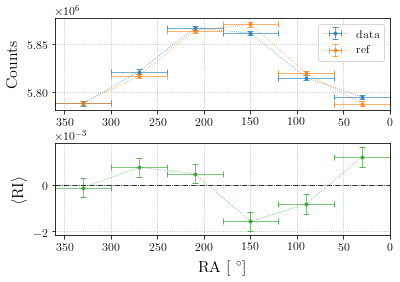

In [146]:
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.35)
ax_counts = plt.subplot(gs[0])
ax_ri = plt.subplot(gs[1], sharex=ax_counts)

ax_counts.errorbar(ra, proj_data, yerr=proj_data_err, xerr=ra_err, marker='.', ls=':',  
            label='data', alpha=0.75)
ax_counts.errorbar(ra, proj_ref, yerr=proj_ref_err, xerr=ra_err, marker='.', ls=':',  
            label='ref', alpha=0.75)
ax_counts.grid()
ax_counts.set_xlim(0, 360)
ax_counts.invert_xaxis()
ax_counts.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax_counts.set_ylabel('Counts')
ax_counts.legend()


ax_ri.errorbar(ra, ri, yerr=ri_err, xerr=ra_err, marker='.', ls=':',  
            label='data', color='C2', alpha=0.75)
ax_ri.axhline(0, marker='None', ls='-.', color='k')
ax_ri.grid()
ax_ri.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax_ri.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax_ri.set_xlabel('RA [ $^{\circ}$]')

# Save plot
outfile = 'proj_data_ref.png'
outfile = os.path.join(comp.paths.figures_dir, 'anisotropy', 'skymaps', outfile)
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

In [147]:
def get_dec_band_proj(skymap, n_ra_bins=10, n_dec_bins=10):
    
    npix = len(skymap)
    nside = hp.npix2nside(npix)
    # Bin in declination
    theta, phi = hp.pix2ang(nside, range(npix))
    thetamax =  np.deg2rad(90 - decmin)
    thetamin = np.deg2rad(90 - decmax)
    theta_bins= np.linspace(thetamin, thetamax, n_dec_bins+1)
    theta_bin_midpoints = (theta_bins[1:] + theta_bins[:-1]) / 2
    theta_bin_num = np.digitize(theta, theta_bins) - 1
    
    dec_band_proj = []
    for idx in range(n_dec_bins):
        projection = {}
        
        skymap_copy = skymap.copy()
        unseen_mask = skymap_copy == hp.UNSEEN
        # Construct mask to get pixels within declination band
        theta_bin_mask = (theta_bin_num == idx)
        combined_mask = theta_bin_mask & ~unseen_mask
        print(combined_mask.sum())
        # Set pixels not in declination band to hp.UNSEEN
        skymap_copy[~combined_mask] = hp.UNSEEN
        
        # Get RA projection of skymap_copy
        proj, proj_err, ra, ra_err = anisotropy.get_RA_proj_map(
            skymap_copy, decmin=decmin, decmax=decmax, n_bins=n_ra_bins)
        
        projection['proj'] = proj
#         print(proj)
        projection['proj_err'] = proj_err
        projection['ra'] = ra
        projection['ra_err'] = ra_err
        projection['dec_bin_mid'] = np.rad2deg(np.pi/2 - theta_bin_midpoints[idx])
        
        dec_band_proj.append(projection)
           
    return pd.DataFrame.from_records(dec_band_proj)

In [148]:
data_dec_band_proj = get_dec_band_proj(data_all, n_ra_bins=n_ra_bins, n_dec_bins=n_dec_bins)
ref_dec_band_proj = get_dec_band_proj(ref_all, n_ra_bins=n_ra_bins, n_dec_bins=n_dec_bins)

1992
1416
840
264
1992
1416
840
264


In [149]:
ref_dec_band_proj

,dec_bin_mid,proj,proj_err,ra,ra_err
0,-59.375,"[368397.750302, 376344.299841, 387761.45031, 3...","[606.957782965, 613.469069995, 622.704946431, ...","[30.0, 90.0, 150.0, 210.0, 270.0, 330.0]","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0]"
1,-68.125,"[1893369.69916, 1908571.85132, 1925564.35181, ...","[1375.99771045, 1381.51071343, 1387.64705592, ...","[30.0, 90.0, 150.0, 210.0, 270.0, 330.0]","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0]"
2,-76.875,"[2398638.50415, 2407631.35645, 2425400.74683, ...","[1548.75385525, 1551.65439336, 1557.36981698, ...","[30.0, 90.0, 150.0, 210.0, 270.0, 330.0]","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0]"
3,-85.625,"[1127780.34814, 1127604.95312, 1132302.40234, ...","[1061.97003166, 1061.88744843, 1064.09698916, ...","[30.0, 90.0, 150.0, 210.0, 270.0, 330.0]","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0]"


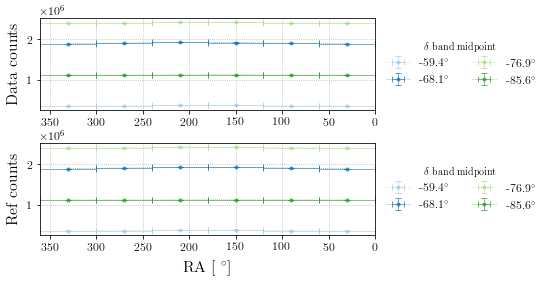

In [150]:
data_colors = sns.color_palette('Paired', n_dec_bins).as_hex()
ref_colors = sns.color_palette('Paired', n_dec_bins).as_hex()

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.35)
ax_data = plt.subplot(gs[0])
ax_ref = plt.subplot(gs[1], sharex=ax_data, sharey=ax_data)

# Plot data
for dec_bin_idx, row in data_dec_band_proj.iterrows():
    ax_data.errorbar(row['ra'], row['proj'], yerr=row['proj_err'], xerr=row['ra_err'], marker='.', ls=':', 
                     label='{:0.1f}'.format(row['dec_bin_mid']) + '$^{\circ}$',
                     color=data_colors[dec_bin_idx], alpha=0.75)
# ax_data.axvline(180, marker='None', ls='-.', color='k')
ax_data.grid()
ax_data.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax_data.set_yscale("log", nonposy='clip')
ax_data.set_xlim(0, 360)
ax_data.invert_xaxis()
ax_data.set_ylabel('Data counts')
ax_data.legend(title='$\mathrm{\delta}$ band midpoint', loc='center left', bbox_to_anchor=(1, 0.5), 
               ncol=2, frameon=False)

# Plot reference
for dec_bin_idx, row in ref_dec_band_proj.iterrows():
    ax_ref.errorbar(row['ra'], row['proj'], yerr=row['proj_err'], xerr=row['ra_err'], marker='.', ls=':',  
                    label='{:0.1f}'.format(row['dec_bin_mid']) + '$^{\circ}$',
                    color=ref_colors[dec_bin_idx], alpha=0.75)
# ax_ref.axvline(180, marker='None', ls='-.', color='k')
ax_ref.grid()
ax_ref.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax_ref.set_yscale("log", nonposy='clip')
ax_ref.set_xlabel('RA [ $^{\circ}$]')
ax_ref.set_ylabel('Ref counts')
ax_ref.legend(title='$\mathrm{\delta}$ band midpoint', loc='center left', bbox_to_anchor=(1, 0.5), 
              ncol=2, frameon=False)

# Save plot
outfile = 'proj_data_dec_bands.png'
outfile = os.path.join(comp.paths.figures_dir, 'anisotropy', 'skymaps', outfile)
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

In [10]:
kwargs_relint = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': scale, 'decmax': decmax}

In [11]:
relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_relint)
relint_light = anisotropy.get_map(name='relint', composition='light', **kwargs_relint)
relint_heavy = anisotropy.get_map(name='relint', composition='heavy', **kwargs_relint)

In [12]:
data_all = anisotropy.get_map(name='data', composition='all', **kwargs_data)
ref_all = anisotropy.get_map(name='ref', composition='all', **kwargs_data)
n_bins = 20
ri, ri_err, ra, ra_err = anisotropy.get_binned_relint(data_all, ref_all, n_bins=n_bins)

In [13]:
ra_bin_edges = np.unique(np.concatenate((ra - ra_err, ra + ra_err)))

In [14]:
np.rad2deg(hp.nside2resol(n_side))

0.91612970981797492

1.74564046048
-2.41129166323


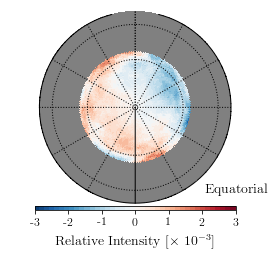

In [19]:
print(relint_all.max())
print(relint_all[relint_all != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_all,
                                 color_palette='RdBu_r', symmetric=True, llabel=None, 
#                                  color_palette='RdBu_r', symmetric=True, llabel='IC86 ' + years_str, 
                                 cbar_title=title, cbar_min=-3.0, cbar_max=3.0, polar=True)

# for ra_bin_edge in ra_bin_edges:
#     dec_points = np.linspace(decmin, decmax, 20)
#     ra_points = [ra_bin_edge]*len(dec_points)
#     hp.projplot(anisotropy.dec_to_healpy_theta(dec_points, input_units='deg'), 
#                 anisotropy.ra_to_healpy_phi(ra_points, input_units='deg'),
#                 marker='None', color='k', ls='-', lw=1)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'all', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

2.50154048043
-3.32322480767


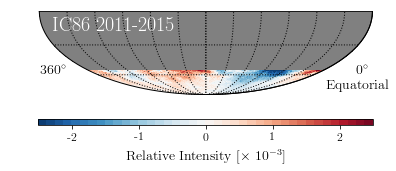

In [75]:
print(relint_light.max())
print(relint_light[relint_light != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_light, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2011-2015', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=False)
# outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'light', n_side, smooth_rad)
# plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

2.86018547065
-2.51354115418


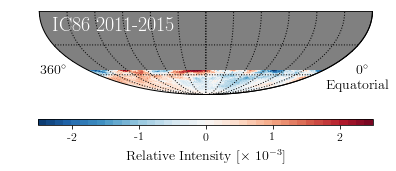

In [76]:
print(relint_heavy.max())
print(relint_heavy[relint_heavy != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_heavy, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2011-2015', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=False)
# outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'heavy', n_side, smooth_rad)
# plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

In [21]:
kwargs_sig = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': None, 'decmax': decmax}

In [22]:
sig_all = anisotropy.get_map(name='sig', composition='all', **kwargs_sig)
sig_light = anisotropy.get_map(name='sig', composition='light', **kwargs_sig)
sig_heavy = anisotropy.get_map(name='sig', composition='heavy', **kwargs_sig)

In [23]:
from scipy.stats import ks_2samp
ks_statistic, pval = ks_2samp(sig_light[sig_light != hp.UNSEEN],
                              sig_heavy[(sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)])

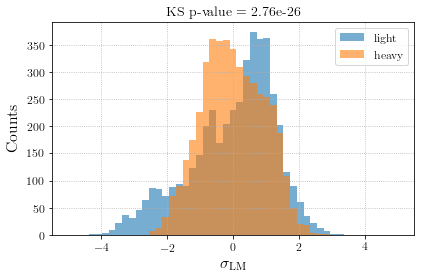

In [24]:
fig, ax = plt.subplots()
# bins = np.linspace(0, 5, 75)
bins = np.linspace(-5, 5, 50)
ax.hist(sig_light[(sig_light != hp.UNSEEN) & ~np.isnan(sig_light)], bins=bins, alpha=0.6, label='light')
ax.hist(sig_heavy[(sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)], bins=bins, alpha=0.6, label='heavy')
ax.set_xlabel('$\mathrm{\sigma_{LM}}$')
ax.set_ylabel('Counts')
ax.set_title('KS p-value = {:0.2e}'.format(pval))
# ax.set_xlim(0, 5)
ax.legend()
ax.grid()
# outfile = 'IC86-{}_sig_dist_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
# plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

3.43941703693
-4.51480241874


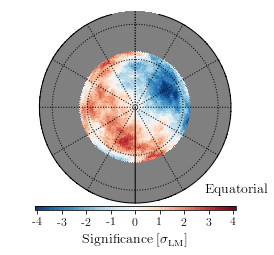

In [25]:
print(sig_all.max())
print(sig_all[sig_all != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_all,
                                 color_palette='RdBu_r', symmetric=True, llabel=None, 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'all', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

3.21513711823
-4.29908513931


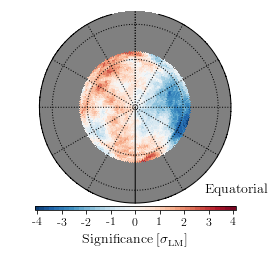

In [29]:
print(sig_light.max())
print(sig_light[sig_light != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_light,
                                 color_palette='RdBu_r', symmetric=True, llabel=None, 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'light', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

In [197]:
sig_heavy

array([ -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30, ...,
         3.00637410e-01,  -7.59083821e-01,   6.57532894e-02])

2.8338798635
-2.47618438952


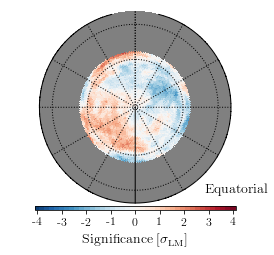

In [30]:
print(sig_heavy[(sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)].max())
print(sig_heavy[(sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_heavy,
                                 color_palette='RdBu_r', symmetric=True, llabel=None, 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'heavy', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

In [157]:
rel_int_diff = anisotropy.get_relint_diff(**kwargs_relint)
print(rel_int_diff.max())
print(rel_int_diff[rel_int_diff != hp.UNSEEN].min())

TypeError: get_relint_diff() got an unexpected keyword argument 'low_energy'

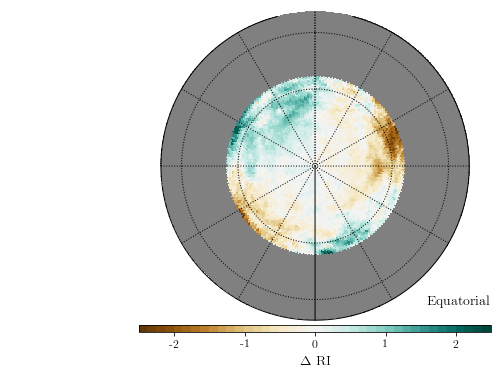

In [31]:
title = '$\mathrm{\Delta \ RI}$'
fig, ax = anisotropy.plot_skymap(rel_int_diff, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='BrBG', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_RI-diff_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

# Projected relative intensity
[ [back to top](#top) ]

In [302]:
# config = ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
# years_str = '2011-2015'
n_bins = 72
smooth_rad = 0.0

kwargs_relint = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': None, 'decmax': decmax}

In [303]:
config

['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']

In [304]:
n_total = anisotropy.get_num_events(config=config, composition='all', decmax=decmax, low_energy=low_energy)
n_light = anisotropy.get_num_events(config=config, composition='light', decmax=decmax, low_energy=low_energy)
n_heavy = anisotropy.get_num_events(config=config, composition='heavy', decmax=decmax, low_energy=low_energy)

In [305]:
print(n_light/n_total)
print(n_heavy/n_total)

0.61907019126
0.380929608455


In [306]:
relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_relint)
relint_all_err = anisotropy.get_map(name='relerr', composition='all', **kwargs_relint)

data_all = anisotropy.get_map(name='data', composition='all', **kwargs_relint)
ref_all = anisotropy.get_map(name='ref', composition='all', **kwargs_relint)

In [307]:
# ri_all, ri_all_err, ra, ra_err = anisotropy.get_proj_relint(relint_all, relint_all_err, n_bins=n_bins)
ri_all, ri_all_err, ra, ra_err = anisotropy.get_binned_relint(data_all, ref_all, n_bins=n_bins, decmax=decmax)

In [308]:
popt_all, perr_all, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_all, sigmay=ri_all_err, l=3)

amp_all = popt_all[1]
amp_err_all = perr_all[1]

phase_all = np.rad2deg(popt_all[2])
phase_err_all = np.rad2deg(perr_all[2])

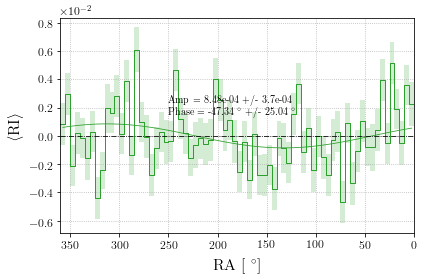

In [309]:
fig, ax = plt.subplots()
# ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', c='C2', label='all')
ra_bins = np.linspace(0, 360, n_bins + 1)
plotting.plot_steps(ra_bins, ri_all, yerr=ri_all_err, color='C2', label='all', fillalpha=0.2, ax=ax)
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_all[:3]), color='C2', marker='None')

ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.grid()
# ax.set_ylim(-1.5e-3, 1.5e-3)
ax.set_xlim(0, 360)
ax.invert_xaxis()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.legend()

all_amp_str = 'Amp = {:0.2e} +/- {:0.1e}'.format(amp_all, amp_err_all)
all_phase_str = 'Phase = {:0.2f} {} +/- {:0.2f} {}'.format(phase_all, '$^{\circ}$', phase_err_all, '$^{\circ}$')
ax.text(250, 1.51e-3, all_amp_str + '\n' + all_phase_str)

# outfile = 'IC86-{}_proj-RI-all_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
# plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

In [310]:
x_ic = [4.125, 4.375, 4.583333333333333, 4.8499999999999996, 5.125, 5.375, 5.7666666666666666, 6.1333333333333329, 6.7333333333333334]
xerr_ic = [[0.5, 0.54166666666666652, 0.54999999999999993, 0.64166666666666672, 0.71666666666666667, 0.7833333333333331, 0.83333333333333348, 0.62500000000000011, 0.58333333333333348], [0.61666666666666636, 0.65000000000000024, 0.68333333333333346, 0.73333333333333328, 0.74166666666666659, 0.74999999999999989, 0.59999999999999976, 0.51666666666666661, 0.4583333333333332]]
amp_ic = [ 0.0007944,   0.00070115,  0.00048197,  0.00031472,  0.00017988,  0.00011893,
  0.00029029,  0.00063821,  0.0003866 ]
amp_err_ic = [  1.07260384e-05,   1.57618747e-05,   1.91776332e-05,   2.57764408e-05,
   3.71511959e-05,   5.22830267e-05 ,  5.69827038e-05 ,  1.23273895e-04,
   5.28291311e-04]

x_it = [6.2117906863000005]
xerr_it = [[0.27018884550400002], [0.36022344665549999]]
amp_it = [ 0.00163095]
amp_err_it = [ 0.0001523]

In [311]:
phase_ic = [ 321.10862242  ,318.77950087 , 316.9174008,   312.54025686  ,283.48826976,
  193.092962  ,  162.93651877 , 166.71452842  , 95.48816018]
phase_err_ic = [  0.77362065 ,  1.28807493  , 2.27989463 ,  4.69291524 , 11.83455049,
  25.18690922 , 11.24715579 , 11.06569559 , 78.25732659]

phase_it = [ 195.8211308]
phase_err_it = [ 5.35145268]

In [312]:
ani_7year_dict = {'log_energy_IC': x_ic, 'log_energy_IC_err': xerr_ic, 'amp_IC': amp_ic, 'amp_IC_err': amp_err_ic,
                  'log_energy_IT': x_it, 'log_energy_IT_err': xerr_it, 'amp_IT': amp_it, 'amp_IT_err': amp_err_it,
                  'phase_IC': phase_ic, 'phase_IC_err': phase_err_ic,
                  'phase_IT': phase_it, 'phase_IT_err': phase_err_it}

In [313]:
def get_dipole_smooth_df(radii=None, n_bins=None):
    dipole_dict = defaultdict(list)
    for radius in pyprind.prog_bar(radii):

        dipole_dict['radius'].append(radius)
        kwargs_relint_radius = {'config': config, 'low_energy': low_energy, 'smooth': radius, 
                                'scale': None, 'decmax': decmax}
        relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_relint_radius)
        relint_all_err = anisotropy.get_map(name='relerr', composition='all', **kwargs_relint_radius)
        data_all = anisotropy.get_map(name='data', composition='all', **kwargs_relint)
        ref_all = anisotropy.get_map(name='ref', composition='all', **kwargs_relint)
#         ri_all, ri_all_err, ra, ra_err = anisotropy.get_proj_relint(relint_all, relint_all_err, n_bins=n_bins)
        ri_all, ri_all_err, ra, ra_err = anisotropy.get_binned_relint(data_all, ref_all, n_bins=n_bins, decmax=decmax)
        dipole_dict['ri_all'].append(ri_all)
        dipole_dict['ri_all_err'].append(ri_all_err)
        dipole_dict['ra'].append(ra)

        popt_all, perr_all, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_all, sigmay=ri_all_err, l=3)

        amp_all = popt_all[1]
        amp_err_all = perr_all[1]

        phase_all = np.rad2deg(popt_all[2])
        phase_err_all = np.rad2deg(perr_all[2])
        
        if amp_all < 0 :
            amp_all *= -1
            phase_all -= 90
            
        dipole_dict['amp_all'].append(amp_all)
        dipole_dict['amp_all_err'].append(amp_err_all)
        dipole_dict['phase_all'].append(phase_all)
        dipole_dict['phase_all_err'].append(phase_err_all)

        
    return pd.DataFrame.from_records(dipole_dict, index='radius')

In [314]:
radii = [smooth_rad]
# radii = np.arange(5, 55, 1, dtype=int)
dipole_df = get_dipole_smooth_df(radii, n_bins=n_bins)

0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [315]:
dipole_df

,amp_all,amp_all_err,phase_all,phase_all_err,ra,ri_all,ri_all_err
radius,,,,,,,
0.0,0.000848,0.00037,-47.344373,25.038119,"[2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5,...","[0.00224028574312, 0.00358401554914, -0.000505...","[0.00154383205699, 0.00143699267156, -0.001555..."


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


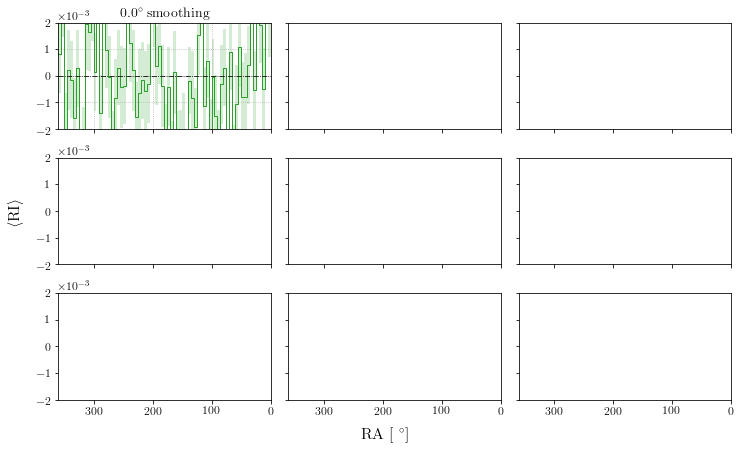

In [316]:
fig, axarr = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
for radius, ax in pyprind.prog_bar(zip(dipole_df.index[::5], axarr.flatten())):
    dipole_radius = dipole_df.loc[radius]
    
    ra_bins = np.linspace(0, 360, n_bins + 1)
    plotting.plot_steps(ra_bins, dipole_radius['ri_all'], yerr=dipole_radius['ri_all_err'],
                        color='C2', label='all', fillalpha=0.2, ax=ax)
    ax.axhline(0, marker='None', ls='-.', c='k')
    ax.set_title(str(radius)+'$^{\circ}$ smoothing')
#     ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
#     ax.set_xlabel('RA [ $^{\circ}$]')
    ax.grid()
    ax.set_ylim(-2.0e-3, 2.0e-3)
    ax.set_xlim(0, 360)
    ax.invert_xaxis()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.text(0.5, -0.025, 'RA [ $^{\circ}$]', ha='center', fontsize=16)
fig.text(-0.025, 0.5, '$\mathrm{\langle RI \\rangle }$', va='center', rotation='vertical', fontsize=16)

plt.tight_layout()
proj_vs_radius_outfile = os.path.join(comp.paths.figures_dir,
#                                 'laputop_performance',
                                'proj_vs_smooth_radius.png')
comp.check_output_dir(proj_vs_radius_outfile)
plt.savefig(proj_vs_radius_outfile)
plt.show()

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


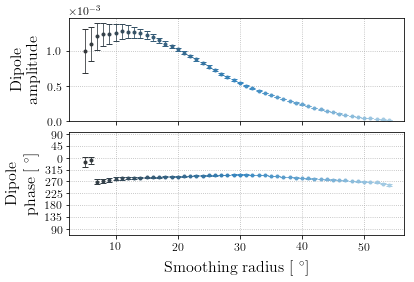

In [46]:
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

colors = sns.color_palette('Blues_d', len(dipole_df.index)).as_hex()
for smooth, color in zip(dipole_df.index, colors):
    print(smooth)
    dipole_radius = dipole_df.loc[smooth]
    ax1.errorbar(smooth, dipole_radius['amp_all'], yerr=dipole_radius['amp_all_err'],
                 marker='.', ls=':', color=color)
    # ax1.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
    ax1.set_ylabel('Dipole \n amplitude')
    # ax1.set_ylim(-0.1, 0.1)
    ax1.tick_params(labelbottom='off')
    ax1.grid()
    # ax1.legend(title='True composition')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


    ax2.errorbar(smooth, 270+dipole_radius['phase_all'], yerr=dipole_radius['phase_all_err'],
                 marker='.', ls=':', color=color)
    offset = 90
    ax2.set_ylim(-25, 370)
    ax2.set_yticks(range(0, 361, 45))
    ylabels = [str(i) for i in range(offset, 360 - 1, 45)]
    ylabels += [str(i) for i in range(0, offset + 1, 45)]
    ax2.set_yticklabels(ylabels)

    ax2.set_ylabel('Dipole \n phase [ $^{\circ}$]')
    ax2.set_xlabel('Smoothing radius [ $^{\circ}$]')
    # ax2.set_ylim(0)
    # ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
    ax2.grid()
ax1.set_ylim(0)
ax1.grid()
ax2.grid()

dipole_vs_radius_outfile = os.path.join(comp.paths.figures_dir,
#                                 'laputop_performance',
                                'proj_dipole_vs_smooth_radius.png')
comp.check_output_dir(dipole_vs_radius_outfile)
plt.savefig(dipole_vs_radius_outfile)
plt.show()

5
10
15
20
25
30
35
40
45
50
5
10
15
20
25
30
35
40
45
50


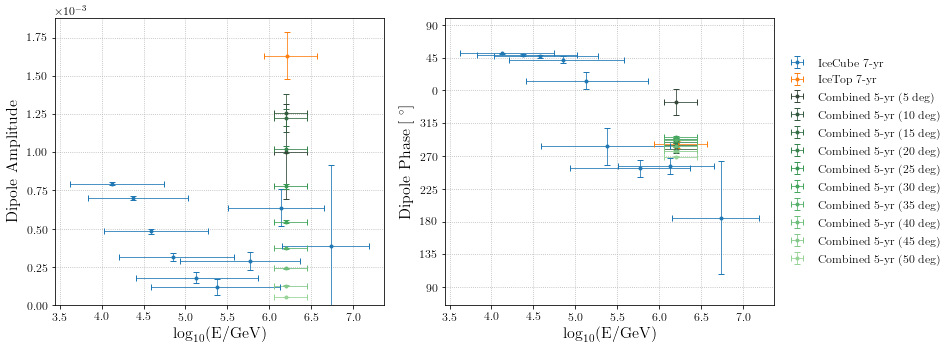

In [34]:
fig, axarr = plt.subplots(1, 2, sharex=True, figsize=(11, 5))
for key, ylabel, ax in zip(['amp', 'phase'],
                           ['Dipole Amplitude', 'Dipole Phase [ $^{\circ}$]'],
                           axarr.flatten()):
    ax.errorbar(ani_7year_dict['log_energy_IC'], ani_7year_dict['{}_IC'.format(key)],
                xerr=ani_7year_dict['log_energy_IC_err'], yerr=ani_7year_dict['{}_IC_err'.format(key)],
                marker='.', ls='None', label='IceCube 7-yr')
    ax.errorbar(ani_7year_dict['log_energy_IT'], ani_7year_dict['{}_IT'.format(key)],
                xerr=ani_7year_dict['log_energy_IT_err'], yerr=ani_7year_dict['{}_IT_err'.format(key)],
                marker='.', ls='None', label='IceTop 7-yr')
    ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
    ax.set_ylabel(ylabel)
    
#     radii = [5, 10]
#     radii = [5, 10, 15, 20, 25, 30]
    colors = sns.color_palette('Greens_d', len(radii)).as_hex()
    for smooth, color in zip(dipole_df.index, colors):
        print(smooth)
        dipole_radius = dipole_df.loc[smooth]
        
        median_log_energy = np.median(log_energy)
        median_log_energy_err_lower = np.abs(np.percentile(log_energy, 16) - np.median(log_energy))
        median_log_energy_err_upper = np.abs(np.percentile(log_energy, 84) - np.median(log_energy))
        if key == 'amp':
            ax.errorbar(median_log_energy, dipole_df.loc[smooth]['amp_all'],
                        xerr=[[median_log_energy_err_lower], [median_log_energy_err_upper]],
                        yerr=dipole_df.loc[smooth]['amp_all_err'], color=color,
                        marker='.', ls='None', label='Combined (5-yr comp analysis)')
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax.set_ylim(0)
        if key == 'phase':
            ax.errorbar(median_log_energy, 270+dipole_df.loc[smooth]['phase_all'],
                        xerr=[[median_log_energy_err_lower], [median_log_energy_err_upper]],
                        yerr=dipole_df.loc[smooth]['phase_all_err'], color=color,
                        marker='.', ls='None', label='Combined 5-yr ({} deg)'.format(smooth))
            offset = 90
            ax.set_ylim(-25, 370)
            ax.set_yticks(range(0, 361, 45))
            ylabels = [str(i) for i in range(offset, 360 - 1, 45)]
            ylabels += [str(i) for i in range(0, offset + 1, 45)]
            ax.set_yticklabels(ylabels)

    ax.grid()
#     ax.legend()
#     ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=4, mode='expand', borderaxespad=0., frameon=False)
    if key == 'phase':
#         ax.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0., frameon=False)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
#         ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode='expand', borderaxespad=0., frameon=False)

    
ani_compare_outfile = 'proj_dipole_vs_radius_7year_comparison.png'
plt.savefig(os.path.join(comp.paths.figures_dir, ani_compare_outfile))
plt.show()

In [319]:
smooth_rad

0.0

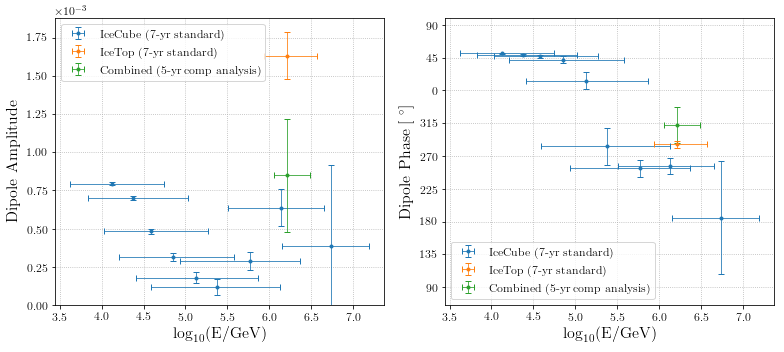

In [320]:
fig, axarr = plt.subplots(1, 2, figsize=(11, 5))
for key, ylabel, ax in zip(['amp', 'phase'],
                           ['Dipole Amplitude', 'Dipole Phase [ $^{\circ}$]'],
                           axarr.flatten()):
    ax.errorbar(ani_7year_dict['log_energy_IC'], ani_7year_dict['{}_IC'.format(key)],
                xerr=ani_7year_dict['log_energy_IC_err'], yerr=ani_7year_dict['{}_IC_err'.format(key)],
                marker='.', ls='None', label='IceCube (7-yr standard)')
    ax.errorbar(ani_7year_dict['log_energy_IT'], ani_7year_dict['{}_IT'.format(key)],
                xerr=ani_7year_dict['log_energy_IT_err'], yerr=ani_7year_dict['{}_IT_err'.format(key)],
                marker='.', ls='None', label='IceTop (7-yr standard)')
    ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
    ax.set_ylabel(ylabel)
    
    median_log_energy = np.median(log_energy)
    median_log_energy_err_lower = np.abs(np.percentile(log_energy, 16) - np.median(log_energy))
    median_log_energy_err_upper = np.abs(np.percentile(log_energy, 84) - np.median(log_energy))
    if key == 'amp':
        ax.errorbar(median_log_energy, dipole_df.loc[smooth_rad]['amp_all'],
                    xerr=[[median_log_energy_err_lower], [median_log_energy_err_upper]],
                    yerr=dipole_df.loc[smooth_rad]['amp_all_err'],
                    marker='.', ls='None', label='Combined (5-yr comp analysis)')
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_ylim(0)
    if key == 'phase':
        ax.errorbar(median_log_energy, 270+dipole_df.loc[smooth_rad]['phase_all'],
                    xerr=[[median_log_energy_err_lower], [median_log_energy_err_upper]],
                    yerr=dipole_df.loc[smooth_rad]['phase_all_err'], 
                    marker='.', ls='None', label='Combined (5-yr comp analysis)')
        offset = 90
        ax.set_ylim(-25, 370)
        ax.set_yticks(range(0, 361, 45))
        ylabels = [str(i) for i in range(offset, 360 - 1, 45)]
        ylabels += [str(i) for i in range(0, offset + 1, 45)]
        ax.set_yticklabels(ylabels)

    ax.grid()
    ax.legend()
#     ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode='expand', borderaxespad=0., frameon=False)
    
ani_compare_outfile = 'proj_dipole_7year_comparison_smooth-{}.png'.format(smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, ani_compare_outfile))
plt.show()

In [190]:
360+dipole_df.loc[smooth_rad]['phase_all']-90

255.71785063353013

In [28]:
[np.percentile(log_energy, 16), np.percentile(log_energy, 84)]

[6.0581239808285368, 6.4461447584566987]

In [47]:
350+phase_all

279.17428532370786

In [223]:
def get_lap_energy(config):
    df_data = comp.load_data(config=config, verbose=False)
    log_energy_mask = (df_data.lap_log_energy > 6.0) & (df_data.lap_log_energy < 7.0)
    log_energy_array = df_data.lap_log_energy[log_energy_mask].values
    
    return log_energy_array

Get median energy for full (all years) dataset

In [224]:
# Set up pool
# pool = mp.Pool(len(config))
# dask.set_options(pool=pool)
# dask.set_options(get=dask.get)

log_energies = [delayed(get_lap_energy)(c) for c in config]
log_energy_array = delayed(np.concatenate)(log_energies)

In [225]:
# with dask.set_options(get=dask.get) as _, ProgressBar() as bar:
with ProgressBar() as bar:
    log_energy = log_energy_array.compute(get=multiprocessing.get, num_works=len(config))

[                                        ] | 0% Completed |  5min  1.1s

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:135: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


[                                        ] | 0% Completed |  5min  4.5s

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:135: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


[#############                           ] | 33% Completed |  5min 23.9s

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:135: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


[########################################] | 100% Completed |  5min 46.7s
[########################################] | 100% Completed |  5min 46.8s
[########################################] | 100% Completed |  5min 46.9s


In [226]:
np.median(log_energy)

6.2131904697923579

In [227]:
np.percentile(log_energy, 16)

6.0604003296802338

In [228]:
np.percentile(log_energy, 84)

6.4837090663435717

In [15]:
relint_light = anisotropy.get_map(name='relint', composition='light', **kwargs_relint)
relint_light_err = anisotropy.get_map(name='relerr', composition='light', **kwargs_relint)
ri_light, ri_light_err, ra, ra_err = anisotropy.get_proj_relint(relint_light, relint_light_err, n_bins=n_bins)

In [16]:
relint_heavy = anisotropy.get_map(name='relint', composition='heavy', **kwargs_relint)
relint_heavy_err = anisotropy.get_map(name='relerr', composition='heavy', **kwargs_relint)
ri_heavy, ri_heavy_err, ra, ra_err = anisotropy.get_proj_relint(relint_heavy, relint_heavy_err, n_bins=n_bins)

In [17]:
popt_light, perr_light, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_light, sigmay=ri_light_err, l=3)
popt_heavy, perr_heavy, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_heavy, sigmay=ri_heavy_err, l=3)

In [18]:
def calc_chi2(ri_0, ri_1, ri_err_0, ri_err_1):
    chi2 = np.sum((ri_0-ri_1)**2/(ri_err_0**2+ri_err_1**2)) / ri_0.shape[0]
    return chi2

In [19]:
calc_chi2(ri_light, ri_heavy, ri_light_err, ri_heavy_err)

3.6527892891573277

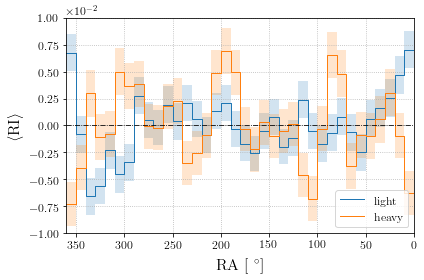

In [20]:
fig, ax = plt.subplots()
plotting.plot_steps(ra_bins, ri_light, yerr=ri_light_err, color='C0', label='light', fillalpha=0.2, ax=ax)
plotting.plot_steps(ra_bins, ri_heavy, yerr=ri_heavy_err, color='C1', label='heavy', fillalpha=0.2, ax=ax)

# ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
# ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.set_xlim(ra_bins.min(), ra_bins.max())
ax.invert_xaxis()
ax.set_ylim(-1e-2, 1e-2)
# ax.set_ylim(-3.5e-3, 3.5e-3)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
outfile = 'IC86-{}_proj-RI-comps_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

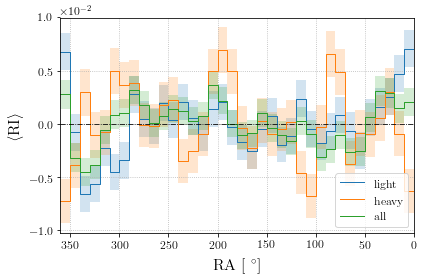

In [21]:
fig, ax = plt.subplots()
# ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
plotting.plot_steps(ra_bins, ri_light, yerr=ri_light_err, color='C0', label='light', fillalpha=0.2, ax=ax)

# ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
plotting.plot_steps(ra_bins, ri_heavy, yerr=ri_heavy_err, color='C1', label='heavy', fillalpha=0.2, ax=ax)

# ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
plotting.plot_steps(ra_bins, ri_all, yerr=ri_all_err, color='C2', label='all', fillalpha=0.2, ax=ax)

ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
# ax.set_ylim(-1.5e-3, 1.5e-3)
ax.set_xlim(0, 360)
ax.invert_xaxis()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

outfile = 'IC86-{}_proj-RI_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

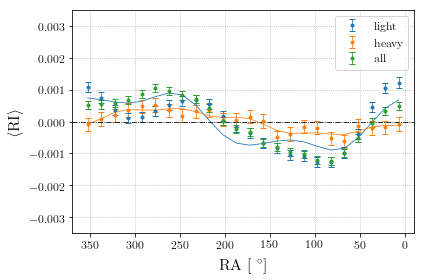

In [30]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
# ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
plotting.plot_steps(ra_bins, ri_all, yerr=ri_all_err, color='C2', label='all', fillalpha=0.2, ax=ax)

ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_light), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_heavy), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-3.5e-3, 3.5e-3)
outfile = 'IC86-{}_proj-RI-fit_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

In [184]:
amp_light = popt_light[1]
amp_heavy = popt_heavy[1]
amp_err_light = perr_light[1]
amp_err_heavy = perr_heavy[1]

phase_light = np.rad2deg(popt_light[2])
phase_heavy = np.rad2deg(popt_heavy[2])
phase_err_light = np.rad2deg(perr_light[2])
phase_err_heavy = np.rad2deg(perr_heavy[2])

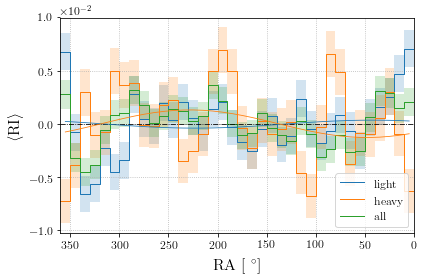

In [187]:
fig, ax = plt.subplots()
# ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
plotting.plot_steps(ra_bins, ri_light, yerr=ri_light_err, color='C0', label='light', fillalpha=0.2, ax=ax)

# ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
plotting.plot_steps(ra_bins, ri_heavy, yerr=ri_heavy_err, color='C1', label='heavy', fillalpha=0.2, ax=ax)

# ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
plotting.plot_steps(ra_bins, ri_all, yerr=ri_all_err, color='C2', label='all', fillalpha=0.2, ax=ax)

ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_light[:3]), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_heavy[:3]), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
# ax.set_ylim(-2e-3, 2e-3)
# ax.set_ylim(-3.5e-3, 3.5e-3)
ax.set_xlim(0, 360)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.invert_xaxis()

light_amp_str = 'light amp = {:0.1e} +/- {:0.1e}'.format(amp_light, amp_err_light)
light_phase_str = 'light phase = {:0.2f}{} +/- {:0.2f}{}'.format(360+phase_light, '$^{\circ}$', phase_err_light, '$^{\circ}$')
# ax.text(25, 2.25e-3, light_amp_str + '\n' + light_phase_str)
# ax.text(325, 0.00235, light_amp_str + '\n' + light_phase_str)

heavy_amp_str = 'heavy amp = {:0.1e} +/- {:0.1e}'.format(amp_heavy, amp_err_heavy)
heavy_phase_str = 'heavy phase = {:0.2f}{} +/- {:0.2f}{}'.format(360+phase_heavy, '$^{\circ}$', phase_err_heavy, '$^{\circ}$')
# ax.text(200, 2.25e-3, heavy_amp_str + '\n' + heavy_phase_str)
# ax.text(160, 0.00235, heavy_amp_str + '\n' + heavy_phase_str)

outfile = 'IC86-{}_proj-RI-dipolefit_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

# Cross-check: random splitting of events
[ [back to top](#top) ]

In [66]:
config = ['IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
n_side = 64
smooth_rad = 20.0
scale = 3
decmax = -55
figures_dir = '/home/jbourbeau/public_html/figures/composition-anisotropy/cross-check-random-split'
years_str = '2012-2015'

In [67]:
rel_int_0 = anisotropy.get_map('relint', config=config, composition='random_0',
                             smooth=smooth_rad, scale=scale, decmax=decmax)
rel_int_1 = anisotropy.get_map('relint', config=config, composition='random_1',
                             smooth=smooth_rad, scale=scale, decmax=decmax)
print(rel_int_0.max())
print(rel_int_0[rel_int_0 != hp.UNSEEN].min())

print(rel_int_1.max())
print(rel_int_1[rel_int_1 != hp.UNSEEN].min())

2.65429851244
-3.36021713829
2.58918508496
-3.14294109658


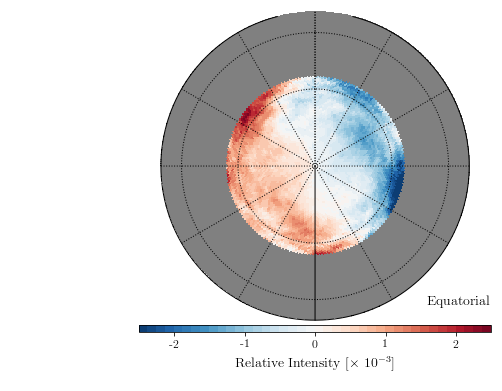

In [68]:
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(rel_int_0, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_0', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

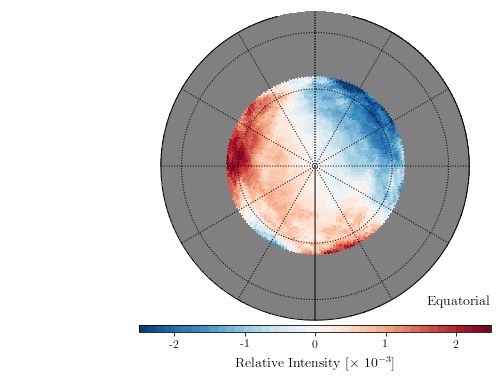

In [69]:
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(rel_int_1, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_1', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

In [70]:
sig_0 = anisotropy.get_map('sig', composition='random_0', config=config, smooth=smooth_rad, decmax=decmax)
sig_1 = anisotropy.get_map('sig', composition='random_1', config=config, smooth=smooth_rad, decmax=decmax)

In [71]:
print(sig_0.max())
print(sig_0[sig_0 != hp.UNSEEN].min())

print(sig_1.max())
print(sig_1[sig_1 != hp.UNSEEN].min())

3.10673742569
-3.66635747678
3.68417830318
-3.60931721794


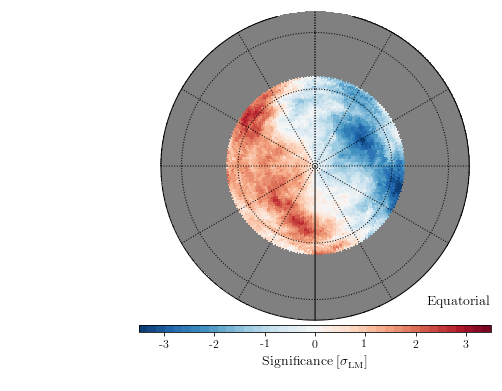

In [72]:
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_0, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-3.5, cbar_max=3.5, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_0', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

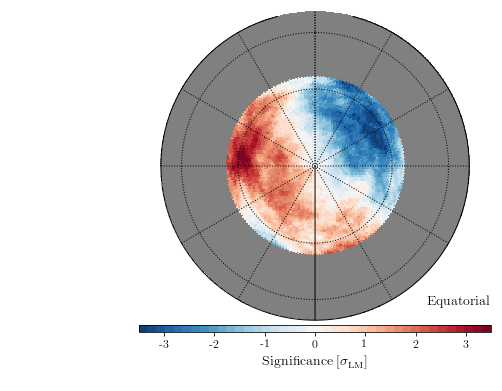

In [73]:
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_1, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-3.5, cbar_max=3.5, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_1', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

In [74]:
relint = anisotropy.get_map('relint', config=config, composition='all',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err = anisotropy.get_map('relerr', config=config, composition='all',
                             smooth=smooth_rad, scale=None, decmax=decmax)

In [75]:
ri_all, ri_all_err, ra, ra_err = anisotropy.get_proj_relint(relint, relint_err)

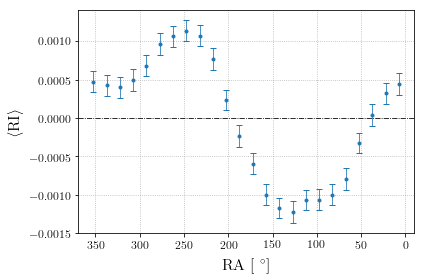

In [76]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.grid()
ax.invert_xaxis()
plt.show()

In [91]:
relint_0 = anisotropy.get_map('relint', config=config, composition='random_0',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err_0 = anisotropy.get_map('relerr', config=config, composition='random_0',
                             smooth=smooth_rad, scale=None, decmax=decmax)
ri_0, ri_err_0, ra, ra_err = anisotropy.get_proj_relint(relint_0, relint_err_0)

In [92]:
relint_1 = anisotropy.get_map('relint', config=config, composition='random_1',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err_1 = anisotropy.get_map('relerr', config=config, composition='random_1',
                             smooth=smooth_rad, scale=None, decmax=decmax)
ri_1, ri_err_1, ra, ra_err = anisotropy.get_proj_relint(relint_1, relint_err_1)

In [93]:
popt_0, perr, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_0, sigmay=ri_err_0)
popt_1, perr, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_1, sigmay=ri_err_1)

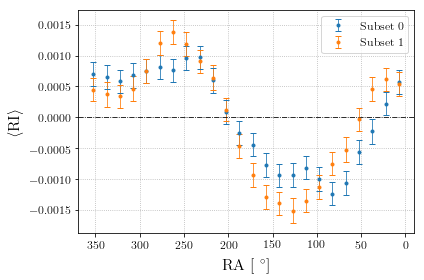

In [94]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

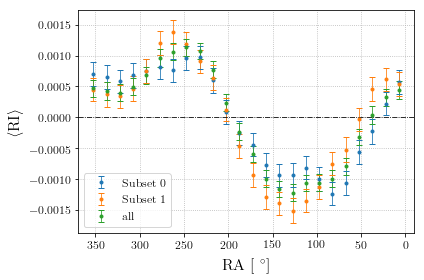

In [95]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

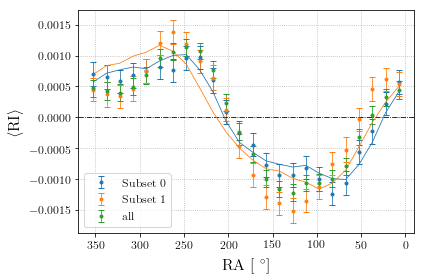

In [96]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_0), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_1), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

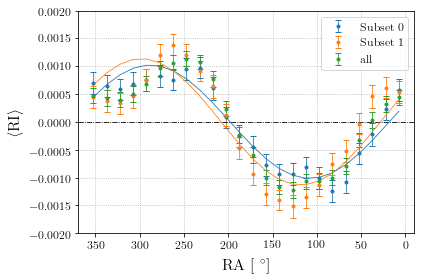

In [97]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_0[:3]), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_1[:3]), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-2e-3, 2e-3)
outfile = 'IC86-{}_proj-RI-dipolefit_random_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))
plt.show()

In [98]:
'{:g}'.format(popt_0[1]), '{:g}'.format(popt_1[1])

('0.0010178', '0.00113404')

In [99]:
np.rad2deg(popt_0[2]), np.rad2deg(popt_1[2])

(-71.862836300904505, -61.870525912281074)

In [3]:
# Load full DataFrame for config
mypaths = comp.get_paths()
df_file = os.path.join(mypaths.comp_data_dir, 'IC86.2013' + '_data',
                       'anisotropy_dataframe.hdf')
with pd.HDFStore(df_file) as store:
    data_df = store['dataframe']

In [6]:
data_df.head()

,lap_zenith,lap_azimuth,start_time_mjd,pred_comp
0,0.206773,5.480972,56414.452644,light
1,0.181282,2.019701,56414.452706,heavy
2,0.220391,3.160242,56414.452744,heavy
3,0.408630,1.879472,56414.452762,light
4,0.061005,1.460350,56414.452762,light


In [5]:
n_side = 64
n_pix = hp.nside2npix(n_side)
bdt_score_skymap = np.zeros(n_pix)

for idx, row in data_df.iterrows():
    
    local_zenith = row['lap_zenith']
    local_azimuth = row['lap_azimuth']
    local_time = row['start_time_mjd']

    ra, dec = astro.dir_to_equa(local_zenith, local_azimuth, local_time)
    hp_theta, hp_phi = anisotropy.equatorial_to_healpy(ra, dec)
    pix = hp.ang2pix(n_side, hp_theta, hp_phi)
    bdt_score_skymap[pix] += row['score']

KeyError: ('lap_zenith', u'occurred at index lap_zenith')

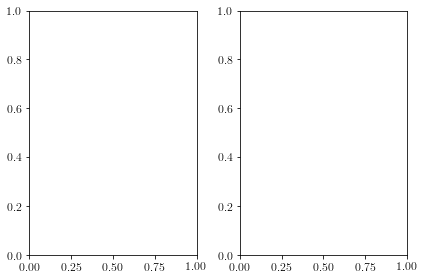

In [80]:
fig, axarr = plt.subplots(1, 2)

In [82]:
ax = axarr[0]

In [ ]:
ax.s